### FRClassifier.ipynb

 Copyright (C) ‹ 2019 › ‹ Anna Scaife - anna.scaife@manchester.ac.uk › 

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

---

**[AMS - 190910]**  Notebook created for **CERN School of Computing, Cluj-Napoca, Sept 2019**<br> 

---

Keep track of your progress:

- [ ] Exercise 1 (intermediate)
- [ ] Exercise 2 (advanced)
- [ ] Exercise 3 (basic)
- [ ] Exercise 4 (advanced)

---

Some standard libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

This tutorial uses the [pytorch library](https://pytorch.org) to build its CNN, so we need to import a bunch of pytoch libraries:

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import torch.optim as optim

We're going to be classifying radio galaxies. So we'll import the custom class [FRDEEP](https://hongmingtang060313.github.io/FR-DEEP/), which provides a pytorch formatted dataset filled with postage stamp images of radio galaxies:

In [5]:
from FRDEEP import FRDEEPF

Some code to control the size of figures in the notebook:

In [6]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300

Our network is defined as a class. We first specify each of the layers individually and then arrange them into a net in the <code>forward</code> function:

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # conv1 output width: input_width - (kernel_size - 1) => 150 - (5-1) = 146
        # pool 1 output width: int(input_width/2) => 73
        x = self.pool(F.relu(self.conv1(x)))
        # conv2 output width: input_width - (kernel_size - 1) => 73 - (5-1) = 69
        # pool 2 output width: int(input_width/2) => 34
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 16 * 34 * 34)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Let's print a summary of what our net looks like:

In [8]:
net = Net()
summary(net,(1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 146, 146]             156
         MaxPool2d-2            [-1, 6, 73, 73]               0
            Conv2d-3           [-1, 16, 69, 69]           2,416
         MaxPool2d-4           [-1, 16, 34, 34]               0
            Linear-5                  [-1, 120]       2,219,640
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 2,233,226
Trainable params: 2,233,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 1.94
Params size (MB): 8.52
Estimated Total Size (MB): 10.55
----------------------------------------------------------------


At this point we've defined our net but we don't have any data to feed it yet. 

To feed data into a pytorch net we use a <code>DataLoader</code>, which can apply [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) to the input data on the fly. This can be used for data augmentation, but for now we'll use a couple of very simple transforms: (1) to convert the PIL images in the dataset to tensor data, and (2) to normalise the values of the image pixels to have a mean of 0.5 and a variance of 0.5.

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])
                               ])

When we run the <code>DataLoader</code> it will check whether the dataset already exists on disk and if it doesn't then it will download it. We do this twice, once for the training data and once for the test data. The designations train/test are specified within the dataset itself. 

Because dataset sizes can be quite large, it's normal to read the data in **batches** of a specified size.

In [10]:
bsize = 8

If you also require a validation dataset it should be a subset of the **training data**. Never take your validation dataset from your test data.

In [11]:
trainset = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

testset = FRDEEPF(root='./FIRST_data', train=False, download=True, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


---

**Exercise 1:** Can you add in a dataloader for a *validation* dataset? 

---

Let's specify the labels for our target classes. We could extract these from the dataset itself, but it's easier just to make a small list:

In [12]:
classes = ('FRI', 'FRII')

Let's have a quick look to see how our input data appear. The images are in tensor form, so to display them we need a function that converts them back to numpy arrays:

In [13]:
def imshow(img):
    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

We'll pull one iteration of our data out of the dataset. The *batch size* is set to 2, so this should return two images and their labels:

In [14]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

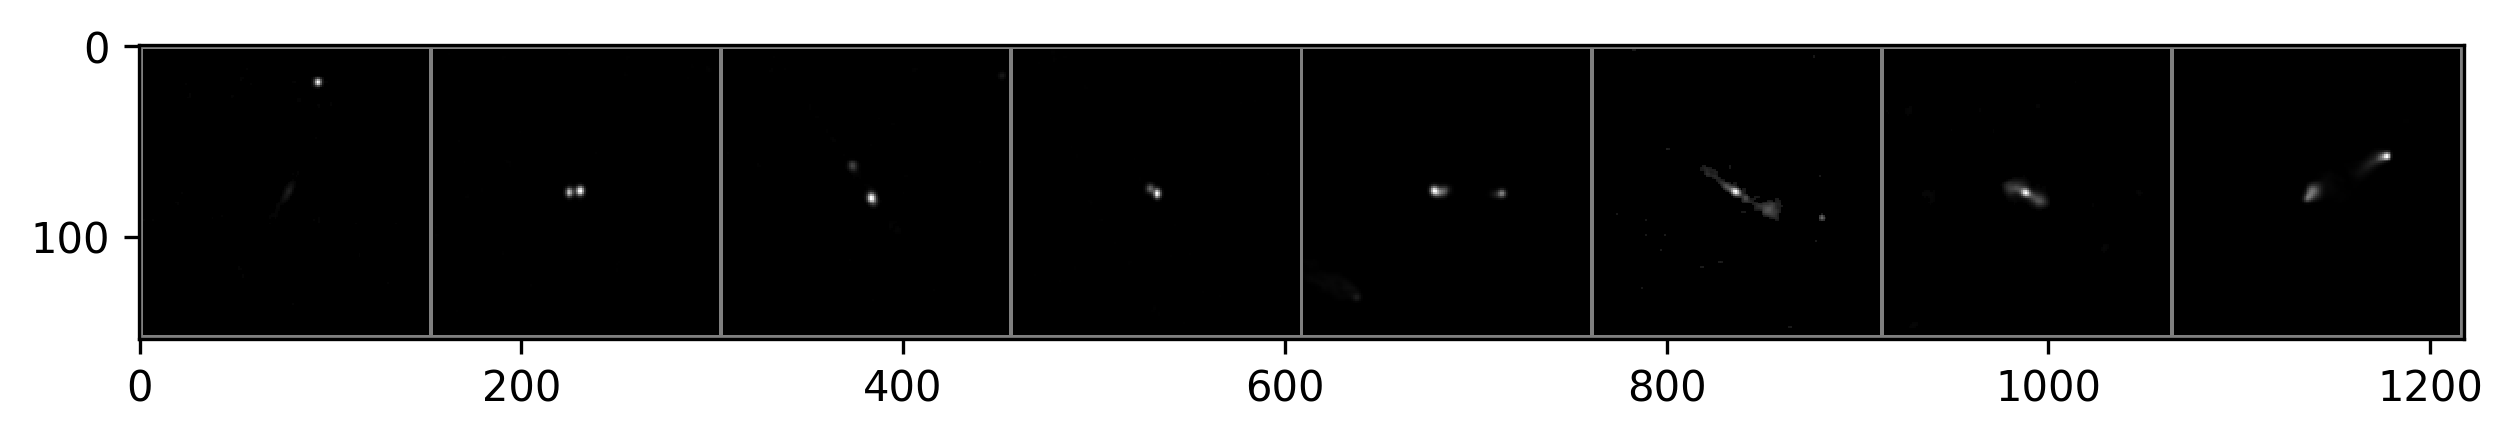

          FRI       FRII       FRII       FRII       FRII        FRI        FRI       FRII


In [15]:
# show images
imshow(torchvision.utils.make_grid(images)) # NOT plt.imshow
# print labels
print('        '+'      '.join('%5s' % classes[labels[j]] for j in range(bsize)))

At this point we have a net and we have some data. Next we need an objective function to optimize and an optimization method to use. Here we're minimizing the [cross entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) and we'll use the [Adagrad optimizer](https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#adagrad). 

We need to specify the *learning rate* for the optimizer, which basically controls the size of each update step in this iterative optimizer.

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.01)

Now let's put it all together. We'll run for 10 **epochs**. In each epoch the whole training dataset is passed forwards and backwards through the network. The full dataset is a bit big to drop on the algorithm all at once, so we feed it through in **batches**. Ideally the **loss** should get smaller with each epoch. 

Why 10 epochs? *Good question...*

Deciding on the right number of epochs is a balancing act. Obviously, the more epochs you use, the longer your code will take to run... but your loss will hopefully keep getting smaller. The more complicated your dataset is, the more epochs you may need to achieve the same kind of loss values. However... if you run too many epochs you run the risk of *over-fitting* your training data. This is why validation is so important. In short: there's no good/simple answer. 

In [17]:
nepoch = 10     # number of epochs
print_num = 50  # record the loss every 50 samples
epoch_history = []  # record of epoch stage
train_history = []  # record of loss at each stage
for epoch in range(nepoch):  # loop over the dataset multiple times
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update the training loss for this epoch
        train_loss += loss.item()
        
        # print statistics
        if i % print_num == (print_num-1):    # print every 50 mini-batches
            
            epoch_history.append(epoch+float(i/len(trainloader)))
            train_history.append(train_loss / print_num)
            train_loss = 0.0
            
        
print('Finished Training')

Finished Training


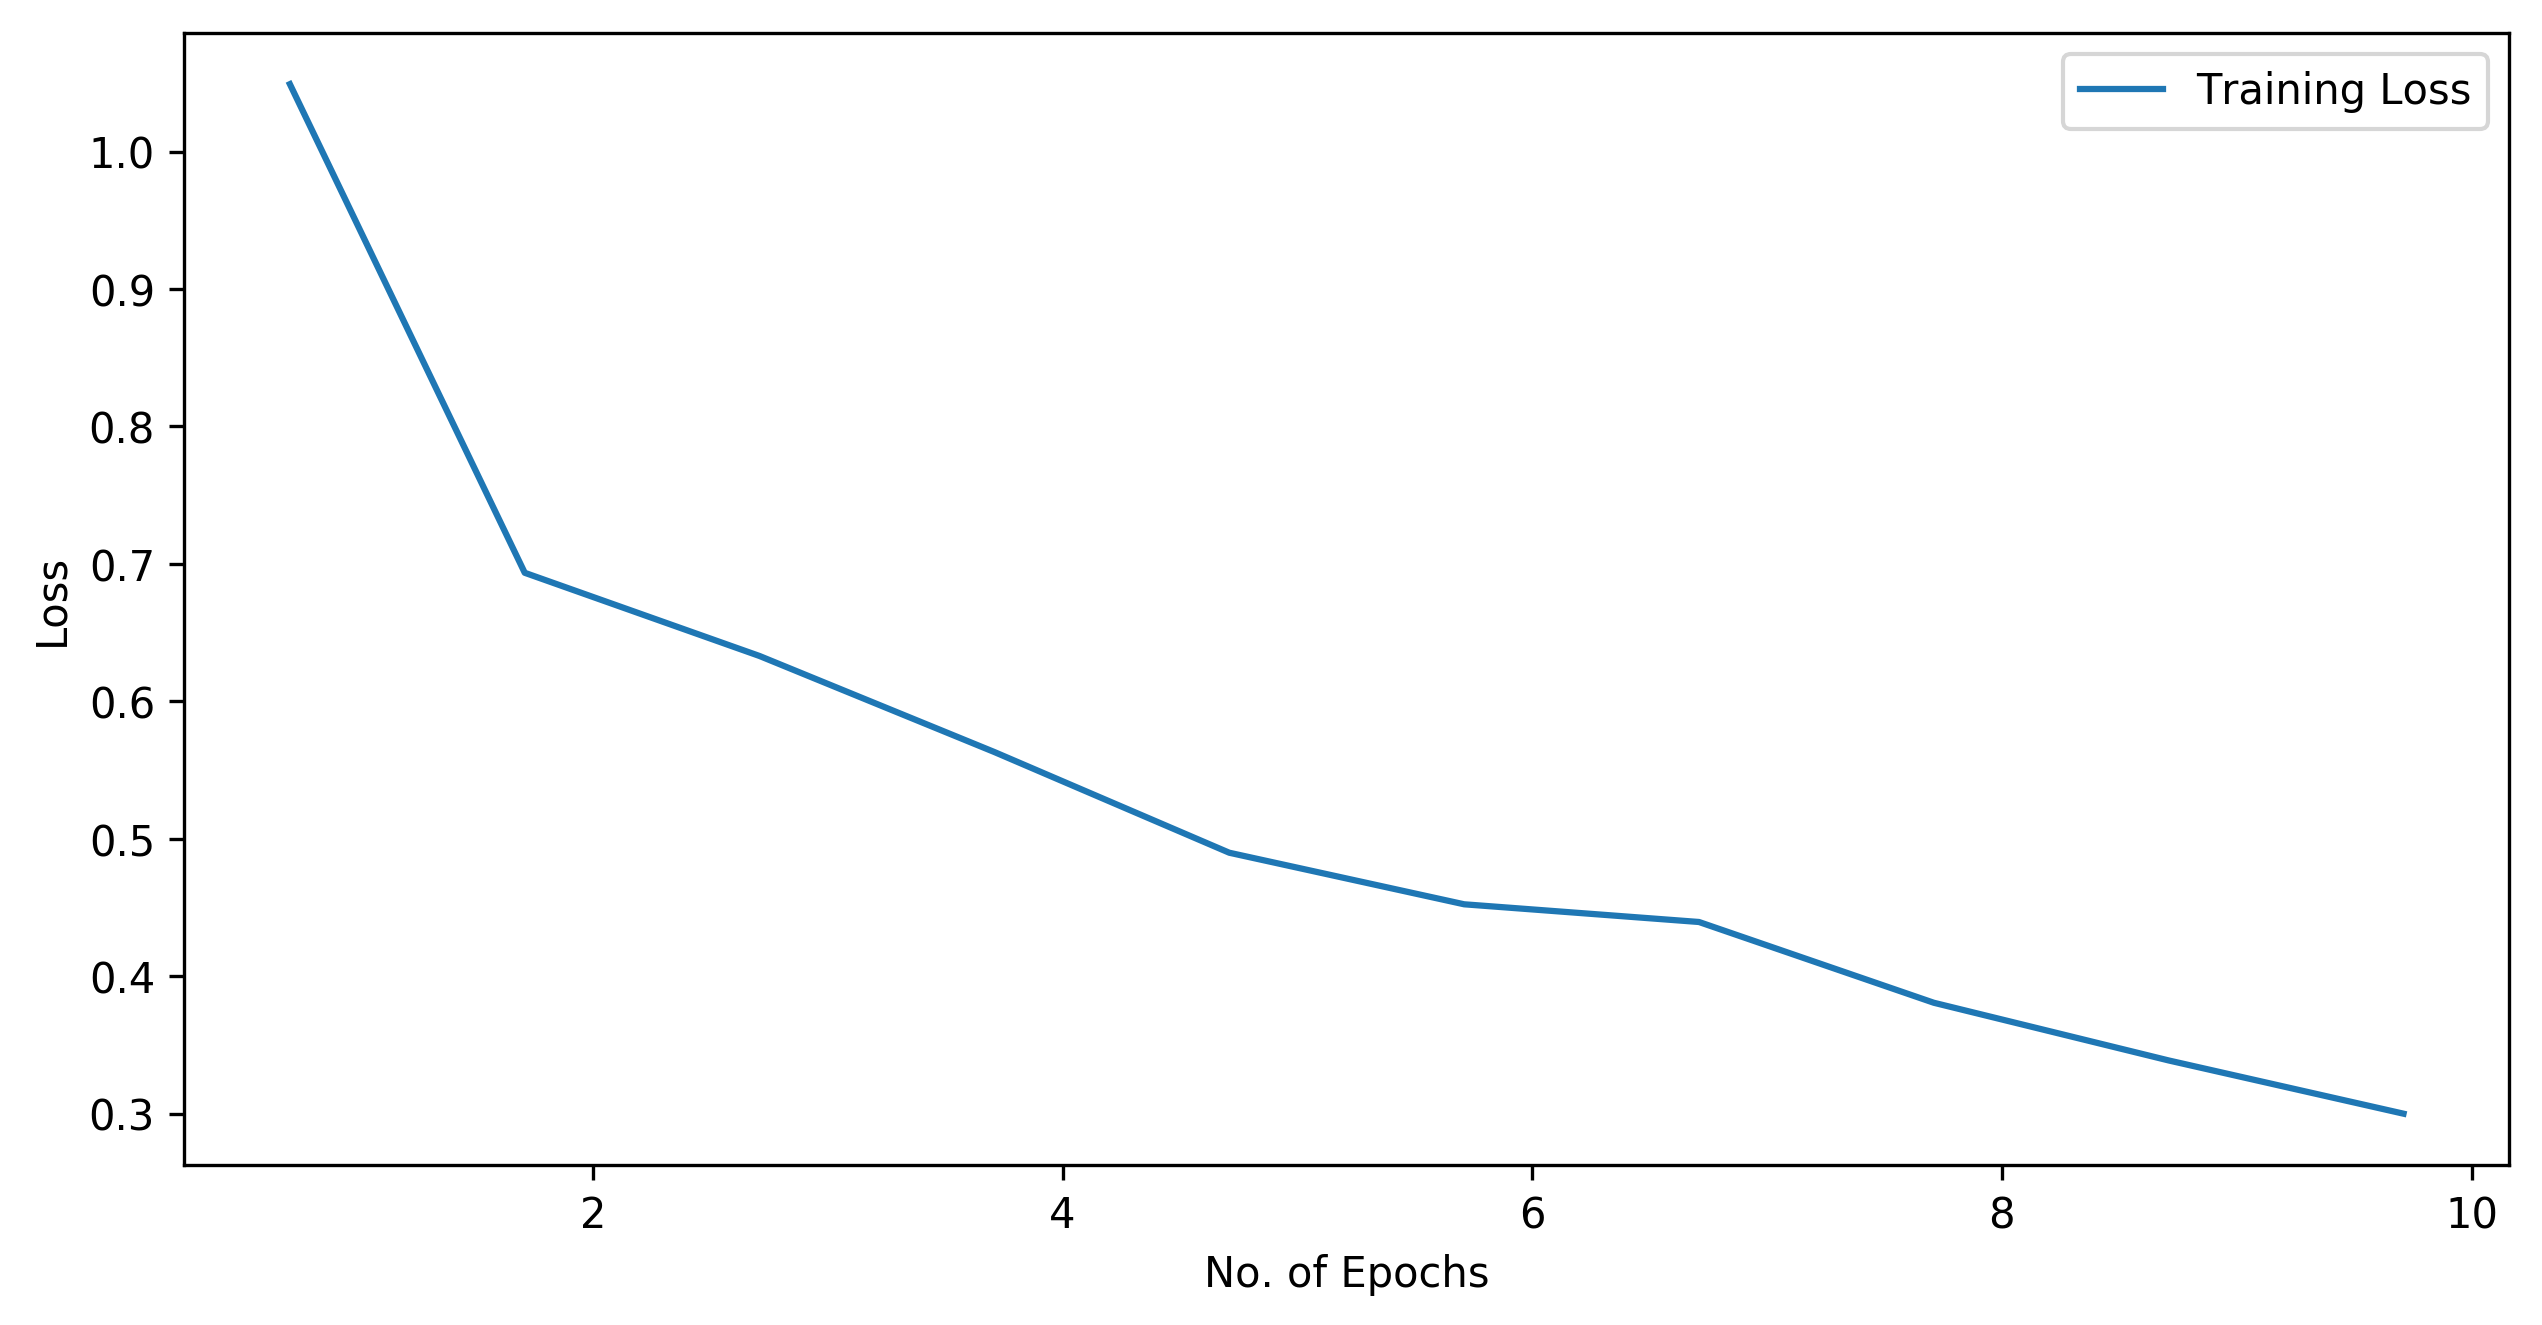

In [18]:
plt.plot(epoch_history, train_history, label="Training Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

**Exercise 2:** Can you amend the code to print out the validation loss after each epoch?

---

Let's see how we did with our 10 epochs. To do this we use our test dataset:

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 50 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 50 test images: 76 %


However, this is an imbalanced dataset (i.e. there are more FRII galaxies than FRI galaxies) so the overall accuracy may not equally represent how well we were able to classify the different types of galaxy. Let's look at the accuracy *per class* instead.

In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [21]:
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   FRI : 59 %
Accuracy of  FRII : 89 %


---

**Exercise 3:** Can you amend the code to print out the validation accuracy at each training epoch and add it to your plot?

**Exercise 4:** Can you use [torchvision.transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) to augment the original dataset and improve your accuracy?

---